In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

from implementations import *
from utilitaries import *

Data Cleaning
===

In [2]:
from proj1_helpers import *

labels, features, indices = load_csv_data('train.csv', sub_sample=False)
# b(background) -> -1 and s(signal) -> 1

n_samples, n_features = np.shape(features)
features = remove_meaningless_data(features)

print(n_samples, n_features)


250000 30


In [3]:
#Missing value ratio: we believe that columns with too many missing 
#values are unlikely to carry much useful information
prop_nan = np.zeros((2,30))

for i in range(n_features):
    n_nan = 0
    for j in range(n_samples):
        if np.isnan(features[j,i]):
            n_nan += 1
    prop_nan[0,i] = i
    prop_nan[1,i] = n_nan/n_samples

print(prop_nan)

[[ 0.        1.        2.        3.        4.        5.        6.
   7.        8.        9.       10.       11.       12.       13.
  14.       15.       16.       17.       18.       19.       20.
  21.       22.       23.       24.       25.       26.       27.
  28.       29.      ]
 [ 0.152456  0.        0.        0.        0.709828  0.709828  0.709828
   0.        0.        0.        0.        0.        0.709828  0.
   0.        0.        0.        0.        0.        0.        0.
   0.        0.        0.399652  0.399652  0.399652  0.709828  0.709828
   0.709828  0.      ]]


In [4]:
clean_data = np.delete(features, np.s_[4,5,6,12,23,24,25,26,27,28], axis=1)

print(np.shape(clean_data))
s_data = clean_data[labels == 1,:]
bg_data = clean_data[labels == -1,:]

n_samples, n_features = np.shape(clean_data)

#0,1,2,3,7,8,9,10,11,13,14,15,16,17,18,19,20,21,22,29
#0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20

(250000, 20)


Features selection
===

2 80.38717859852684 81.59631342457085 0.014894128007652349
4 2.386378161952677 2.3661778401173224 0.008512208993830603
5 18.445728448527436 19.163180201176885 0.037925630094691416
12 45.68388045571807 47.16916763522846 0.031831988478235
15 42.74076678300863 41.18366586747641 0.03732512313673192
4 0.000490571820956872
7 0.0008559155136582978


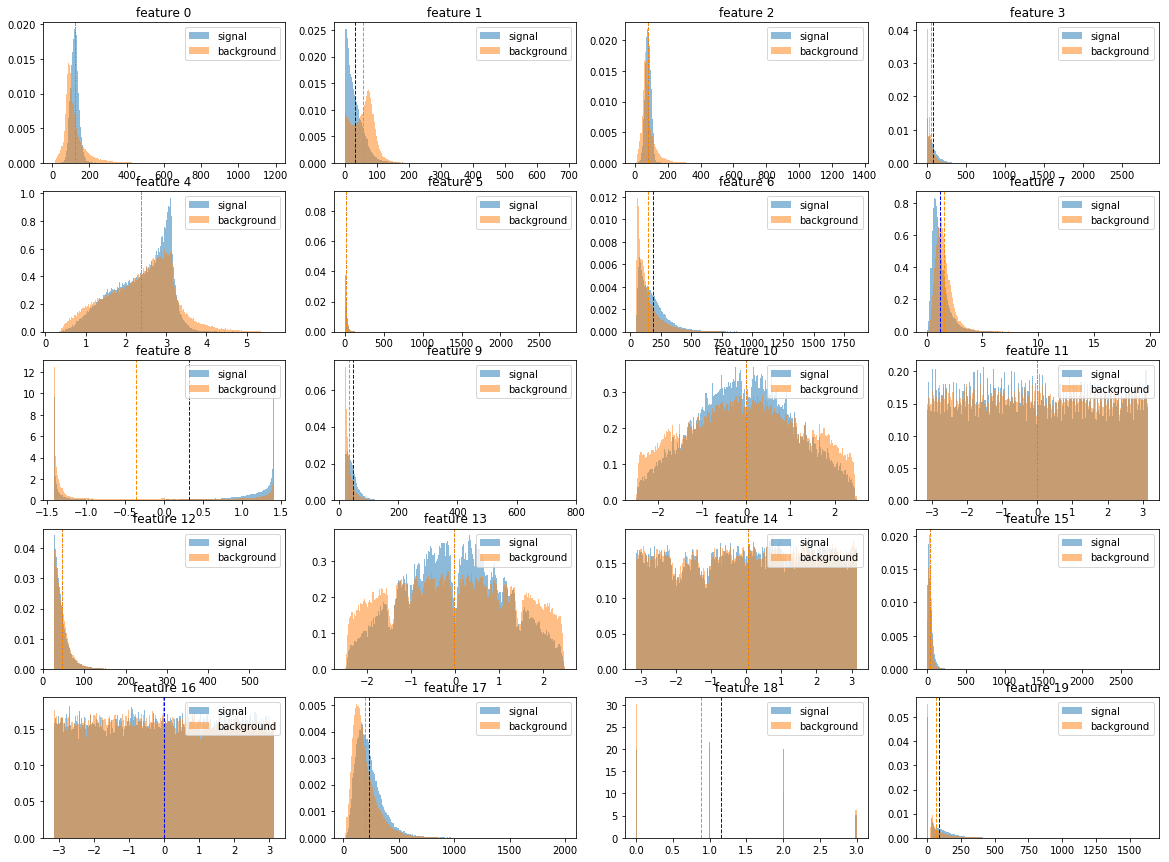

In [5]:
plt.figure(figsize=(20,15))

pics = 200

for i in range(n_features):
    plt.subplot(5,4,i+1)
    plt.hist(s_data[:,i][~np.isnan(s_data[:,i])], pics, density=1, alpha=0.5, label='signal')
    plt.hist(bg_data[:,i][~np.isnan(bg_data[:,i])], pics, density=1, alpha=0.5, label='background')
    plt.axvline(s_data[:,i][~np.isnan(s_data[:,i])].mean(), color='b', linestyle='dashed', linewidth=1)
    plt.axvline(bg_data[:,i][~np.isnan(bg_data[:,i])].mean(), color='darkorange', linestyle='dashed', linewidth=1)
    plt.legend(loc='upper right')
    plt.title(f'feature {i}') 
    
# Mean discrimination
    threshold_mean = 0.05
    diff_mean = (np.abs(np.abs((s_data[:,i]).mean()) - np.abs((bg_data[:,i]).mean())))/np.abs((clean_data[:,i]).mean())
    if diff_mean < threshold_mean:
        print(i,s_data[:,i].mean(),bg_data[:,i].mean(),diff_mean)
# useless features : 2,4,5,12,15

#low variance filter : data columns with too little changes carry little info
threshold_var = 0.001
variances = np.var(clean_data, axis = 0) / np.linalg.norm(clean_data, axis = 0)
for i in range(n_features):
    if variances[i] < threshold_var:
        print(i,variances[i])
#useless features: 4,7

feature=6 and feature=17 [[1.         0.90448146]
 [0.90448146 1.        ]]
feature=6 and feature=19 [[1.         0.96562839]
 [0.96562839 1.        ]]
feature=17 and feature=6 [[1.         0.90448146]
 [0.90448146 1.        ]]
feature=17 and feature=19 [[1.         0.88441286]
 [0.88441286 1.        ]]
feature=19 and feature=6 [[1.         0.96562839]
 [0.96562839 1.        ]]
feature=19 and feature=17 [[1.         0.88441286]
 [0.88441286 1.        ]]
Applying PCA on training dataset
(250000, 20)


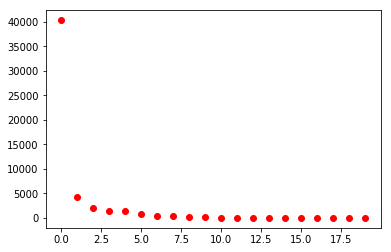

In [6]:
#high correlation filter : data columns with similar trends carry similar info
correlation_pairs = np.ones((2,2))
for i in range(n_features):
    for j in range(n_features):
        correlation_pairs = np.corrcoef(clean_data[:,i],clean_data[:,j])
        #print("feature={f1} and feature={f2}".format(f1=i,f2=j), np.corrcoef(std_data[:,i],std_data[:,j]))
        if correlation_pairs[0,1] > 0.85 and i != j:
            print("feature={f1} and feature={f2}".format(f1=i,f2=j), np.corrcoef(clean_data[:,i],clean_data[:,j]))
# results: high correlated > 0.85
# features 6 and 17 + 6 and 19 + 17 and 19

# useless feature = 19

#Principal component analysis:
def PCA(data, k):
    """Apply PCA to a given set of datapoints in d-dimension"""
    norm_data = data - (np.nanmean(data, axis=0))
    norm_data[:,0][np.isnan(norm_data[:,0])] = 0
    cov_matrix = np.cov(norm_data.T)
    eigenValues, eigenVectors = np.linalg.eig(cov_matrix)
    
    sort_indices = eigenValues.argsort()[::-1]
    eigenValues = eigenValues[sort_indices]
    eigenVectors = eigenVectors[:,sort_indices]
    
    return eigenValues, eigenVectors

print("Applying PCA on training dataset")
eig_val, eig_vec = PCA(clean_data, 7)
PCA_data = clean_data.dot(eig_vec)
print(np.shape(PCA_data))

plt.plot([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19], eig_val, 'ro')

In [18]:
from additional_functions import *

# 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29
# 0 1 2 3       4 5 6 7  8     9  10 11 12 13 14 15 16 17 18                   19
# 0 1   2           3    4     5  6  7     8  9     10 11 12

#kept features = 0,1,3,9,11,13,14,15,17,18,20,21,22

#clean_data_2 = np.delete(clean_data, np.s_[2,4,5,7,12,15,19], axis=1)
clean_data_2 = np.delete(clean_data, np.s_[4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19], axis=1)
std_data = standardize(clean_data_2)
std_data[:,0][np.isnan(std_data[:,0])] = 0

n_samples, n_features = np.shape(std_data)
print(np.shape(std_data))

def ridge_regression_demo(std_data,labels,degree,ratio,seed):
    """ridge regression demo."""
    # define parameter
    lambdas = np.logspace(-5, -1, 10)
    # split data
    x_tr, x_te, y_tr, y_te = split_data(std_data,labels,ratio, seed)
    # form tx
    tx_tr = build_poly(x_tr, degree)
    tx_te = build_poly(x_te, degree)
    # ridge regression with different lambda
    rmse_tr = []
    rmse_te = []
    for ind, lambda_ in enumerate(lambdas):
         # ridge regression
            weight_tr,loss_tr = ridge_regression(y_tr, tx_tr, lambda_)
            weight_te,loss_te = ridge_regression(y_te, tx_te, lambda_)
            rmse_tr.append(np.sqrt(2 * loss_tr))
            rmse_te.append(np.sqrt(2 * loss_te))

            #print("proportion={p}, degree={d}, lambda={l:.3f}, Training RMSE={tr:.3f}, Testing RMSE={te:.3f}".format(
               #p=ratio, d=degree, l=lambda_, tr=rmse_tr[ind], te=rmse_te[ind]))
    plot_train_test(rmse_tr, rmse_te, lambdas, degree)

(250000, 4)


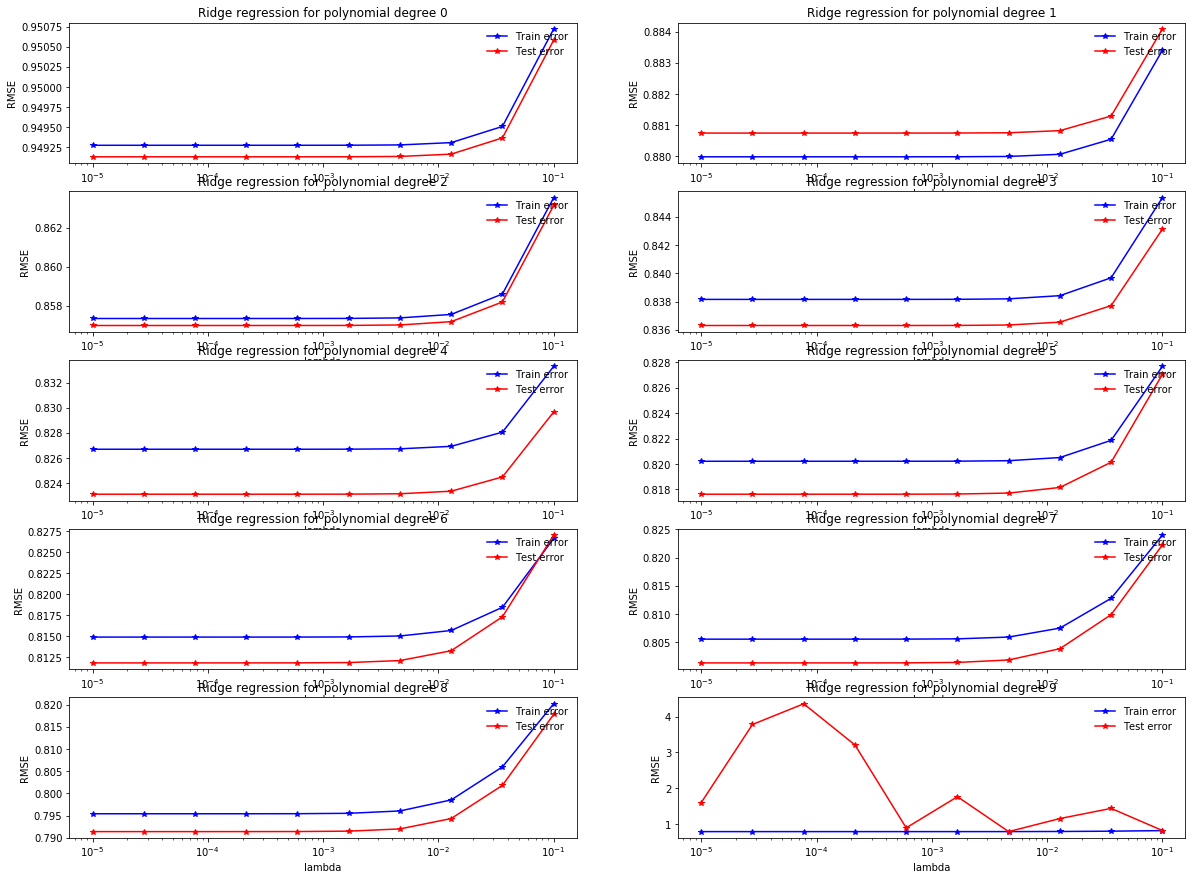

In [19]:
seed = 56
split_ratio = 0.5
plt.figure(figsize=(20,15))



for degree in range(10):
    plt.subplot(5,2,degree+1)
    ridge_regression_demo(std_data,labels,degree, split_ratio, seed)
    


Submission trials
===

In [20]:
chosen_lambda = 0.001
chosen_degree = 8
std_data_poly = build_poly(std_data,chosen_degree)
weights,loss=ridge_regression(labels,std_data_poly,chosen_lambda)
labels_te,features_te, indices_te = load_csv_data('test.csv', sub_sample=False)
needed_weights = np.zeros(30)
positions = [0,1,2,3]
for i in range(n_features):
    needed_weights[positions[i]] = weights[i]
print(needed_weights)

y_pred = predict_labels(needed_weights,features_te)
create_csv_submission(indices_te, y_pred, 'submission_ridge_1.csv')

[-0.05974807  0.66402959 -0.57298559 -0.05881994  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]
